In [2]:
import sys
import re 
import numpy as np 
import pandas as pd
import music21
from glob import glob
import IPython
from tqdm import tqdm
import pickle
from keras.utils import np_utils
from music21 import converter, instrument, note, chord, stream
import tensorflow as tf

import mitdeeplearning as mdl

In [391]:
songs = glob('midiclassics/*/*.mid')

In [393]:
song = songs[:3]

In [394]:
song

['midiclassics\\Albéniz\\Aragon (Fantasia) Op.47 part 6.mid',
 'midiclassics\\Albéniz\\Castilla (Seguidillas) Op.47 part 7.mid',
 'midiclassics\\Albéniz\\Cataluna (Curranda), No.2 from Suite Espanola.mid']

In [429]:
song_index = np.random.choice(len(songs), 100 , replace=False)
song_index

array([1239, 1000,  580,  936,  753,  416,   70,  797,  329, 1231, 1215,
        701,  636, 1513,  108,  190, 1116,  619, 1115, 1502, 1303, 1124,
       1198,  734,  871,  618,  189,  472,  945,  757,  770,    6, 1304,
       1103, 1470,  966,   88,  974, 1491, 1504, 1352,  483,  178,   39,
       1593,  312, 1195,  581, 1570, 1338,  955,  601, 1045,  426, 1027,
       1373,  567,  899,  892, 1596, 1567,  111,  251, 1174,  608, 1485,
        927, 1067, 1084,   77,  115, 1314, 1746, 1429,  148,  393,  557,
       1690, 1155, 1302,  559,  446,  980,   98,  680,  417,  933,   13,
        528,  288, 1387,  664, 1157, 1053,  366, 1051, 1789, 1165, 1461,
       1311])

In [430]:
def get_notes():
    notes = []
    for i in tqdm(song_index):
        # converting .mid file to stream object
        try:
            midi = converter.parse(songs[i])
            notes_to_parse = []
            try:
                # Given a single stream, partition into a part for each unique instrument
                parts = instrument.partitionByInstrument(midi)
            except:
                pass
            if parts: # if parts has instrument parts 
                notes_to_parse = parts.parts[0].recurse()
            else:
                notes_to_parse = midi.flat.notes
        
            for element in notes_to_parse: 
                if isinstance(element, note.Note):
                    # if element is a note, extract pitch
                    notes.append(str(element.pitch))
                elif(isinstance(element, chord.Chord)):
                    # if element is a chord, append the normal form of the 
                    # chord (a list of integers) to the list of notes. 
                    notes.append('.'.join(str(n) for n in element.normalOrder))
        except:
            pass
    with open('data/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)
    
    return notes

In [ ]:
get_notes()

In [3]:
with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)

In [4]:
# Find all unique characters in the joined string
vocab = sorted(set(notes))
print("There are", len(vocab), "unique characters in the dataset")

There are 539 unique characters in the dataset


In [6]:
#Vectorize the text
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

In [437]:
# Vectorizing whole song data
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

# def vectorize_string(string):

vectorized_songs = vectorize_string(notes)

In [438]:
len(vectorized_songs)

77972

In [439]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  '''TODO: construct a list of input sequences for the training batch'''
  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  
  '''TODO: construct a list of output sequences for the training batch'''
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]
  

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch

In [440]:
#sample check
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=2)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: [ 77  55 535 353  57] (array(['1.5', '1.3', 'G5', '7.10', '1.3.5'], dtype='<U14'))
  expected output: [ 55 535 353  57  77] (array(['1.3', 'G5', '7.10', '1.3.5', '1.5'], dtype='<U14'))
Step   1
  input: [493 493 155   8 154] (array(['D4', 'D4', '2.3', '0.2', '2'], dtype='<U14'))
  expected output: [493 155   8 154 493] (array(['D4', '2.3', '0.2', '2', 'D4'], dtype='<U14'))


In [441]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [442]:
### Defining the RNN Model ###

'''Add LSTM and Dense layers to define the RNN model using the Sequential API.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    #  Call the LSTM function defined above to add this layer.
    LSTM(rnn_units), 

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    # Add the Dense layer.
    tf.keras.layers.Dense(vocab_size)
  
  ])

  return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

In [443]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (32, None, 256)           137984    
                                                                 
 lstm_7 (LSTM)               (32, None, 1024)          5246976   
                                                                 
 dense_7 (Dense)             (32, None, 539)           552475    
                                                                 
Total params: 5,937,435
Trainable params: 5,937,435
Non-trainable params: 0
_________________________________________________________________


In [445]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 539) # (batch_size, sequence_length, vocab_size)


In [446]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([ 60, 211,  75, 521,  14, 126, 529, 292, 523, 174,  67,  85, 399,
       262,  97, 236, 352, 141, 106,  57, 469, 323, 157,  95, 350, 205,
       154,  92, 316, 530, 342, 242, 121, 457, 387, 421,  43, 341, 538,
       227, 429, 333, 163, 286, 111, 415, 235,  56, 413, 208, 453, 164,
       498, 441,  16, 453, 374, 348,  92, 222, 350, 261, 280, 139, 145,
       154, 338, 205, 404, 375, 339, 275, 465, 269, 294, 177,  18, 537,
       505, 321, 187,  54, 131,  24, 486, 431, 454, 388, 331, 295, 118,
       516, 496, 187, 466, 281, 504, 180,  51, 160], dtype=int64)

In [447]:
print("Input: \n", repr(" ".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr(" ".join(idx2char[sampled_indices])))

Input: 
 '9.1 4.6 G5 3.6 B3 E-6 3.6 E-6 7.10.1 E6 G5 B3 F#5 E-6 3.6 E-6 7.10.1 E6 G5 11.3.6 F#5 E-6 5.8.11 D6 F5 9.0.4 E5 C6 3.6.9 E-5 C6 7.11.2 B5 D5 0.3.6 C5 A5 4.7.11 G5 6.9.0 F#5 6.9.11 E-5 4.7.11 E2 4.7.11 B4 11.0 A4 B1 B4 B3 B2 B4 9 A3 A4 G1 G4 G3 G2 11.2 7 D4 11.2 0.4 C2 E4 C3 E5 11 D4 D5 A1 C5 C4 A2 E5 0 E4 E5 D3 F5 F4 B2 D4 F4 G#2 B3 F4 F5 D3 F4 D4 B2 F4 B3 G#2 F4 D3'

Next Char Predictions: 
 '1.3.6.7 3.5.8.9 1.4.7.9.10 F5 0.2.5.8 11.0.3.7 G#6 5.7.9.1 F7 2.4.8.9 1.4.5 1.7 8.10.3 4.7.8.10 10.1 4.5.7.10.0 7.0.1 11.2.3.6 10.11.0 1.3.5 B-5 6.7.10.11 2.3.5 10.0.4 7 3.5 2 10.0.2.4 6.11 G#7 6.8.9.11 4.6.10 11.0.2 A2 8.0.2 9.0.2 1.2.4.7 6.8.9.1 G9 3.7.9.10 9.1.3 6.8.0 2.4.5 5.7.10 10.11.2.4 8.9.11.2.5 4.5.7 1.3.4 8.9.11 3.5.7 9.2 2.4.5.6 E-3 9.10.3 0.2.6.8 9.2 7.9.0 6.9.11 10.0.2.4 3.7.10 7 4.7.8 5.6.7.8 11.2 11.2.5 2 6.8.11.1 3.5 8.11.1.4 7.9.0.3 6.8.11.2 5.11 B-1 4.8.9 5.7.9.11 2.5.6 0.3 G7 E3 6.7.10.0 2.5.9 1.2.7.8 11.1.2.4 0.3.6.7 C3 9.10 9.2.3 8.0.3 6.7.9.11 5.8 10.3.4 F#7 D7 2.

In [448]:
### Defining the loss function ###

'''define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  
  return loss

'''compute the loss using the true next characters from the example batch 
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred)


print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 539)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       6.2893133


In [481]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 1000  # Increase this to train longer
batch_size = 12  # Experiment between 1 and 64
seq_length = 300  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

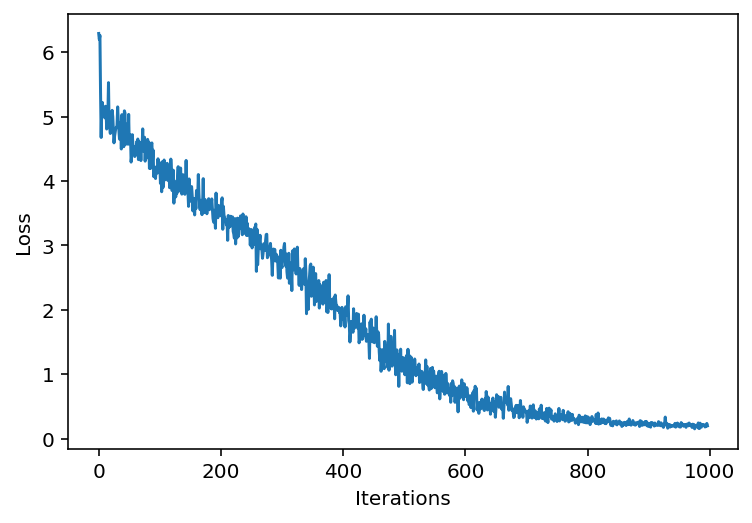

100%|██████████| 1000/1000 [06:01<00:00,  2.77it/s]


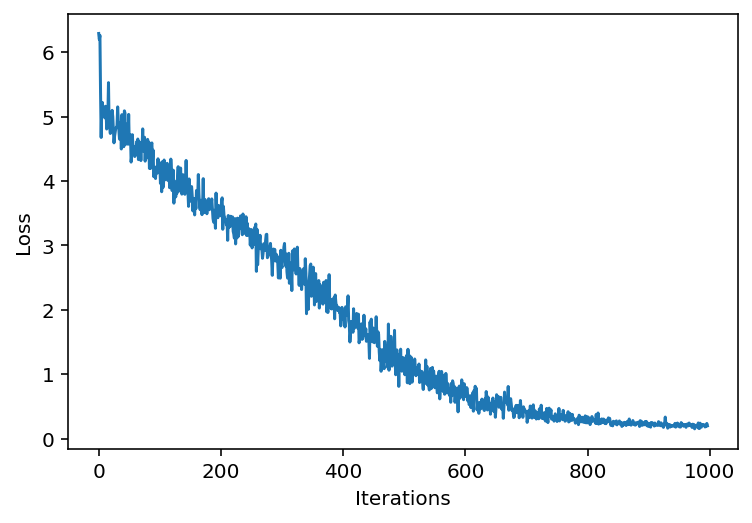

In [482]:
### Define optimizer and training operation ###

'''instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)



'''Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)


@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''feed the current input into the model and generate predictions'''
    y_hat = model(x) 
 
  
    ''' compute the loss!'''
    loss = compute_loss(y, y_hat) 
    

  # Now, compute the gradients 
  '''complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)

  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [483]:
'''Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (1, None, 256)            137984    
                                                                 
 lstm_13 (LSTM)              (1, None, 1024)           5246976   
                                                                 
 dense_13 (Dense)            (1, None, 539)            552475    
                                                                 
Total params: 5,937,435
Trainable params: 5,937,435
Non-trainable params: 0
_________________________________________________________________


In [484]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating notes text using the learned RNN model)
  
  '''convert the start string to numbers (vectorize)'''
  input_eval = [char2idx[s] for s in start_string] 
  
  input_eval = tf.expand_dims(input_eval, 0)
  
  # Empty string to store our results
  text_generated = []
  
  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      ''' evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
     
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      ''' add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id])
 
  return text_generated

In [485]:
generated_text = generate_text(model, start_string=["F#5"], generation_length=1000) 

100%|██████████| 1000/1000 [00:11<00:00, 84.50it/s]


In [ ]:
a = ["F#5"]
a.extend(generated_text)
a

In [487]:
len(a)

1001

In [488]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    
    print('Saving Output file as midi....')

    midi_stream.write('midi', fp='generated_output.mid')

In [489]:
create_midi(a)

Saving Output file as midi....
